# PACKAGES & IMPORTS

### Packages

In [1]:
!pip install requests
!pip install google-search-results
!pip3 install matplotlib
!pip3 install --upgrade bleach
!pip3 install MTCNN
!pip3 install tensorflow
!pip install tqdm
!pip install datasets transformers torch torchvision facenet-pytorch
!pip install opencv-python pillow
!pip install insightface
!pip install onnxruntime

!pip install numpy==1.24.3
!pip install --force-reinstall scikit-image lazy_loader numpy
# !pip uninstall albumentations
# this version is important for insightface
!pip install albumentations==1.3.1
!pip install insightface opencv-python numpy
!pip install --upgrade insightface

  Using cached numpy-1.24.3-cp38-cp38-macosx_10_9_x86_64.whl.metadata (5.6 kB)
  Using cached typing_extensions-4.5.0-py3-none-any.whl.metadata (8.5 kB)
Using cached numpy-1.24.3-cp38-cp38-macosx_10_9_x86_64.whl (19.8 MB)
Using cached typing_extensions-4.5.0-py3-none-any.whl (27 kB)
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.13.2
    Uninstalling typing_extensions-4.13.2:
      Successfully uninstalled typing_extensions-4.13.2
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.4
    Uninstalling numpy-1.24.4:
      Successfully uninstalled numpy-1.24.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albucore 0.0.17 requires typing-extensions>=4.9.0; python_version < "3.10", but you have typing-extensions 4.5.0 which is incompatible.
facenet-pytorch 2.6.0 requires Pillow<10.3.0,>=10.2.0, 

### Imports

In [2]:
import requests
from pathlib import Path
from serpapi import GoogleSearch
import urllib.request
import os
from matplotlib import pyplot
from PIL import Image
from numpy import asarray
from mtcnn.mtcnn import MTCNN

import skimage
import lazy_loader
import numpy
print("skimage:", skimage.__version__)
print("lazy_loader:", lazy_loader.__version__)
print("numpy:", numpy.__version__)

from insightface.app import FaceAnalysis
import os
import numpy as np
import cv2

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import cv2
import matplotlib.pyplot as plt
import math


2025-10-15 21:52:03.445595: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


skimage: 0.21.0
lazy_loader: 0.4
numpy: 1.24.4


# FUNCTIONS

### get_main_cast_refined
Searches and filters cast members using TMDB (the movie database) API. I'm using my private key here. The filtering is done by always including the top five (most prominent / important) characters and then characters with a high popularity score from there. Higher prominensce characters have a lower popularity threshold for inclusion. However, it should be said that these popularit metrics are a little arbitrary. I've also chosen to include (assuming popularity is high enough) no more than 60% of the cast.

In [3]:
def get_main_cast_refined(movie_id, min_popularity=2.5, always_include_top_n=5, verbose=False):
    url = f"https://api.themoviedb.org/3/movie/{movie_id}/credits"
    params = {"api_key": API_KEY}
    response = requests.get(url, params=params).json()
    cast = response.get("cast", [])

    total_cast = len(cast)
    if total_cast == 0:
        print("No cast found.")
        return []

    # sort by order (prominence of role in film)
    cast = sorted(cast, key=lambda c: c.get("order", 999))

    # range cutoffs
    cutoff_5 = always_include_top_n
    cutoff_12 = max(int(total_cast * 0.1), cutoff_5)
    cutoff_30 = max(int(total_cast * 0.3), cutoff_12)
    cutoff_60 = max(int(total_cast * 0.6), cutoff_30)

    main_cast = []
    excluded = []

    # go through cast members
    for i, c in enumerate(cast[:cutoff_60]):
        name = c["name"]
        character = c.get("character", "").lower()
        popularity = c.get("popularity", 0)
        order = c.get("order", 999)

        # filters
        if "uncredited" in character:
            reason = "uncredited role"
            excluded.append((name, character, order, popularity, reason))
            continue
        if "voice" in character or "the ring" in character:
            reason = "non-human or object role"
            excluded.append((name, character, order, popularity, reason))
            continue
        if len(character) <= 1 or "#" in character:
            reason = f"character '{character}' likely one of many extras or name is too short"
            continue

        # 1 Top 5 always include
        if i < cutoff_5:
            main_cast.append((name, character, order, popularity))
            continue

        # Next 7% lower standards
        if i < cutoff_12:
            if popularity >= min_popularity - 0.5: # added a baby bias
                main_cast.append((name, character, order, popularity))
            else:
                reason = f"popularity {popularity:.1f} < {min_popularity}"
                excluded.append((name, character, order, popularity, reason))
            continue

        # top 30% (excluding top 12% etc) lower standards but not quite as low as before
        if i < cutoff_30:
            if popularity >= min_popularity - 0.3: # added a baby bias
                main_cast.append((name, character, order, popularity))
            else:
                reason = f"popularity {popularity:.1f} < {min_popularity}"
                excluded.append((name, character, order, popularity, reason))
            continue

        # next 30%, fully require popularity
        if i < cutoff_60:
            if popularity >= min_popularity:
                main_cast.append((name, character, order, popularity))
            else:
                reason = f"popularity {popularity:.1f} < {min_popularity}"
                excluded.append((name, character, order, popularity, reason))
            continue

    if verbose:
        print(f"\nSelected {len(main_cast)} Cast Members:")
        for name, char, ord, pop in main_cast:
            print(f"  - {name} as '{char}' (order={ord}, pop={pop:.1f})")

        if excluded:
            print(f"\nExcluded {len(excluded)} Cast Members:")
            for name, char, ord, pop, why in excluded:
                print(f"  - {name} as '{char}' (order={ord}, pop={pop:.1f}) ➜ {why}")

    return {name: character.title() for name, character, _, _ in main_cast}

In [4]:
def edit_main_cast_quickly(main_cast_dict, full_cast_list):
    """
    🎯 Simple interactive prompt to add/remove cast members using numbers!

    Parameters:
    - main_cast_dict: dict from get_main_cast_refined() → {actor name: character}
    - full_cast_list: list of (name, character, order, popularity) from TMDB

    Returns:
    - Updated dict with modifications
    """
    main_cast = main_cast_dict.copy()
    name_to_char = {name: character.title() for name, character, *_ in full_cast_list}

    print("\n🎬 All Available Cast Members:\n")
    for idx, (name, character, order, pop) in enumerate(full_cast_list):
        status = "✅" if name in main_cast else "❌"
        print(f"{idx:2d}. {status} {name} as '{character.title()}' (pop={pop:.1f})")

    # --- Add step ---
    add_input = input("\n➕ Enter numbers to ADD to main cast (comma-separated), or press Enter to skip: ")
    if add_input.strip():
        to_add = [int(i.strip()) for i in add_input.split(",") if i.strip().isdigit()]
        for i in to_add:
            if 0 <= i < len(full_cast_list):
                name, char, *_ = full_cast_list[i]
                main_cast[name] = char.title()
                print(f"  ✅ Added: {name} as '{char.title()}'")

    # --- Remove step ---
    remove_input = input("\n➖ Enter numbers to REMOVE from main cast, or press Enter to skip: ")
    if remove_input.strip():
        to_remove = [int(i.strip()) for i in remove_input.split(",") if i.strip().isdigit()]
        for i in to_remove:
            if 0 <= i < len(full_cast_list):
                name, *_ = full_cast_list[i]
                if name in main_cast:
                    del main_cast[name]
                    print(f"  🗑️ Removed: {name}")
                else:
                    print(f"  ⚠️ {name} is not in main cast.")

    print("\n🎉 Final main cast:")
    for name, char in main_cast.items():
        print(f"  • {name} as '{char}'")
    return main_cast


### download_google_images
Searches a particular query and saves images into the specified directory.

In [5]:
def download_google_images(query, save_dir, limit=10):
    params = {
        "q": query,
        "tbm": "isch",  # image search
        "api_key": "c411b34061b2e806e6d9c37f118a844d19e12d7d08bdcc3e73fc67cbce4b3a4d",  # 🗝️ Put your key here
    }
    search = GoogleSearch(params)
    results = search.get_dict()
    images = results.get("images_results", [])[:limit]

    os.makedirs(save_dir, exist_ok=True)
    for i, image in enumerate(images):
        url = image["original"]
        try:
            urllib.request.urlretrieve(url, f"{save_dir}/{i+1}.jpg")
        except:
            pass

### extract_face
I'm not sure i ever use this, need to check

In [6]:
# extract a single face from a given photograph
def extract_face(filename, required_size=(224, 224)):
	# load image from file
	pixels = pyplot.imread(filename)
	# create the detector, using default weights
	detector = MTCNN()
	# detect faces in the image
	results = detector.detect_faces(pixels)
	# extract the bounding box from the first face
	x1, y1, width, height = results[0]['box']
	x2, y2 = x1 + width, y1 + height
	# extract the face
	face = pixels[y1:y2, x1:x2]
	# resize pixels to the model size
	image = Image.fromarray(face)
	image = image.resize(required_size)
	face_array = asarray(image)
	return face_array

# START SCRIPT

In [7]:
movie_input = input('What are you watching?\n')
print(movie_input)

Oppenheimer


In [ ]:
API_KEY = "690ab4202579c002623a560fed33737d"

search_url = f"https://api.themoviedb.org/3/search/movie"

# set up query for the movie using my key and user input
params = {
    "api_key": API_KEY,
    "query": movie_input
}

# search for the movie using the API
response = requests.get(search_url, params=params)
results = response.json().get("results", [])

# check if results are empty
if not results:
    print("No results found for this movie 💔")
    quit()
    exit()


# Give user options
print("\n🔍 Search Results 🎬 🎥:")
for i, movie in enumerate(results):
    name = movie["title"]
    year = movie.get("release_date", "????")[:4]
    print(f"{i+1}. {name} ({year})")


🔍 Search Results 🎬 🎥:
1. Oppenheimer (2023)
2. The Ballad of Oppenheimer Park (2016)
3. The Oppenheimer Case (1970)
4. The Trials of J. Robert Oppenheimer (2008)
5. Oppenheimer and The Manhattan Project (2024)
6. Inside Christopher Nolan's Oppenheimer (2023)
7. Oppenheimer: The Real Story (2023)
8. Oppenheimer After Trinity (2023)
9. Oppenheimer: Genius or Madman? (2023)
10. To End All War: Oppenheimer & the Atomic Bomb (2023)
11. In der Sache I. Robert Oppenheimer (1964)
12. Innovations in Film: 65mm Black and White Film in Oppenheimer (2023)
13. Oppenheimer: O Gênio Arrependido (2023)
14. In der Sache J. Robert Oppenheimer (1981)
15. Josef Süß Oppenheimer (1984)
16. The Real Oppenheimer (2023)
17. Joshua Oppenheimer on Night and Fog (2016)
18. Schaffende Hände: Max Oppenheimer (1924)
19. Spionagefall Robert Oppenheimer (2025)
20. Oppenheimer, la véritable histoire de la bombe atomique. (2025)


In [9]:
# choose the movie
error_num = 0
while True:
    if error_num >= 3:
        print("❗❗❗ Too many invalid attempts ⚠️ Exiting 🪂")
        break

    try:
        choice = int(input("\nEnter the number next to your movie: ")) - 1
        if 0 <= choice < len(results):
            movie = results[choice]
            print(f"\n🎬 You chose: {movie['title']} ({movie.get('release_date', '????')[:4]})")
            movie_id = movie["id"]
            break
        else:
            print("⚠️ Invalid choice. Try again.")
            error_num += 1
    except ValueError:
        print("⚠️ Please enter a number.")
        error_num += 1


🎬 You chose: Oppenheimer (2023)


In [10]:
# verbose toggles whether or not it tells you which cast members it has chosen to include or exclude
main_cast = get_main_cast_refined(movie_id, verbose=True)


Selected 8 Cast Members:
  - Cillian Murphy as 'j. robert oppenheimer' (order=0, pop=4.3)
  - Emily Blunt as 'kitty oppenheimer' (order=1, pop=7.3)
  - Matt Damon as 'leslie groves' (order=2, pop=9.1)
  - Robert Downey Jr. as 'lewis strauss' (order=3, pop=5.4)
  - Florence Pugh as 'jean tatlock' (order=4, pop=4.3)
  - Rami Malek as 'david hill' (order=7, pop=2.6)
  - Jason Clarke as 'roger robb' (order=10, pop=3.0)
  - Dane DeHaan as 'kenneth nichols' (order=15, pop=2.3)

Excluded 40 Cast Members:
  - Josh Hartnett as 'ernest lawrence' (order=5, pop=2.0) ➜ popularity 2.0 < 2.5
  - Casey Affleck as 'boris pash' (order=6, pop=1.8) ➜ popularity 1.8 < 2.5
  - Kenneth Branagh as 'niels bohr' (order=8, pop=2.2) ➜ popularity 2.2 < 2.5
  - Benny Safdie as 'edward teller' (order=9, pop=1.4) ➜ popularity 1.4 < 2.5
  - Dylan Arnold as 'frank oppenheimer' (order=11, pop=1.1) ➜ popularity 1.1 < 2.5
  - Tom Conti as 'albert einstein' (order=12, pop=0.9) ➜ popularity 0.9 < 2.5
  - James D'Arcy as 'p

In [11]:
main_cast_raw = get_main_cast_refined(movie_id, verbose=True)

# full_cast_list is what the function internally builds – so we mimic it here:
url = f"https://api.themoviedb.org/3/movie/{movie_id}/credits"
params = {"api_key": API_KEY}
response = requests.get(url, params=params).json()
full_cast = sorted(response.get("cast", []), key=lambda c: c.get("order", 999))
full_cast_list = [(c["name"], c.get("character", ""), c.get("order", 999), c.get("popularity", 0))
                  for c in full_cast]

# Launch editor! 🔧
main_cast_final = edit_main_cast_quickly(main_cast_raw, full_cast_list)


Selected 8 Cast Members:
  - Cillian Murphy as 'j. robert oppenheimer' (order=0, pop=4.3)
  - Emily Blunt as 'kitty oppenheimer' (order=1, pop=7.3)
  - Matt Damon as 'leslie groves' (order=2, pop=9.1)
  - Robert Downey Jr. as 'lewis strauss' (order=3, pop=5.4)
  - Florence Pugh as 'jean tatlock' (order=4, pop=4.3)
  - Rami Malek as 'david hill' (order=7, pop=2.6)
  - Jason Clarke as 'roger robb' (order=10, pop=3.0)
  - Dane DeHaan as 'kenneth nichols' (order=15, pop=2.3)

Excluded 40 Cast Members:
  - Josh Hartnett as 'ernest lawrence' (order=5, pop=2.0) ➜ popularity 2.0 < 2.5
  - Casey Affleck as 'boris pash' (order=6, pop=1.8) ➜ popularity 1.8 < 2.5
  - Kenneth Branagh as 'niels bohr' (order=8, pop=2.2) ➜ popularity 2.2 < 2.5
  - Benny Safdie as 'edward teller' (order=9, pop=1.4) ➜ popularity 1.4 < 2.5
  - Dylan Arnold as 'frank oppenheimer' (order=11, pop=1.1) ➜ popularity 1.1 < 2.5
  - Tom Conti as 'albert einstein' (order=12, pop=0.9) ➜ popularity 0.9 < 2.5
  - James D'Arcy as 'p

In [12]:
print("\n🎉 Final Main Cast:")
print(main_cast_final)


🎉 Final Main Cast:
{'Cillian Murphy': 'J. Robert Oppenheimer', 'Emily Blunt': 'Kitty Oppenheimer', 'Matt Damon': 'Leslie Groves', 'Robert Downey Jr.': 'Lewis Strauss', 'Florence Pugh': 'Jean Tatlock', 'Rami Malek': 'David Hill', 'Jason Clarke': 'Roger Robb', 'Dane DeHaan': 'Kenneth Nichols'}


### Image Scraping
Now that we have our cast, it's time to google the characters and image scrape. Keep in mind that these queries are LIMITED and should be used carefully. This script will download images of the cast and save them. This first part is an optional sanity check that all of the search queries are what they are meant to be.

In [13]:
actor_dict = main_cast_final
print(actor_dict)

{'Cillian Murphy': 'J. Robert Oppenheimer', 'Emily Blunt': 'Kitty Oppenheimer', 'Matt Damon': 'Leslie Groves', 'Robert Downey Jr.': 'Lewis Strauss', 'Florence Pugh': 'Jean Tatlock', 'Rami Malek': 'David Hill', 'Jason Clarke': 'Roger Robb', 'Dane DeHaan': 'Kenneth Nichols'}


In [14]:
Errors ! # prevents accidental execution of image scraping.
# there are a limited number of attempts at image scraping (though fairly high) so this is simply a failsafe against using it accidentally.

SyntaxError: invalid syntax (411886220.py, line 1)

**SPECIFY** THE NUMBER HERE!!! It's set to 75 right now, but you can set it higher. It's also set not to query if it finds that the folder already exists. This is to prevent needless querying. However, if you change the number and run it again, you'll need to manually delete the folders so that you're getting the new number of entries into them when you requery.

In [ ]:
for actor, role in actor_dict.items():
    search_query = f"{actor} {role} {movie['title']} face"
    print(search_query)
    if os.path.exists(f"faces/{role}"):
        continue
    download_google_images(search_query, save_dir=f"faces/{role}", limit=100)


Cillian Murphy J. Robert Oppenheimer Oppenheimer face
Emily Blunt Kitty Oppenheimer Oppenheimer face
Matt Damon Leslie Groves Oppenheimer face
Robert Downey Jr. Lewis Strauss Oppenheimer face


In [ ]:
actor_dict['Michael B. Jordan'] = 'Smoke'
print(actor_dict)


{'Elijah Wood': 'Frodo', 'Ian McKellen': 'Gandalf', 'Viggo Mortensen': 'Aragorn', 'Sean Astin': 'Sam', 'Ian Holm': 'Bilbo', 'Liv Tyler': 'Arwen', 'Sean Bean': 'Boromir', 'Orlando Bloom': 'Legolas', 'Cate Blanchett': 'Galadriel', 'Andy Serkis': 'Gollum', 'Michael B. Jordan': 'Smoke'}


# MACHINE LEARNING PART!
### Get embeddings from the faces

In [ ]:
# read in embedding extractor
face_app = FaceAnalysis(
    name="auraface",
    root="models",
    providers=["CPUExecutionProvider"]
)
face_app.prepare(ctx_id=0) # use cpu

X = []
y = []

data_dir = "./faces"  # folder structure: ./faces/person1/*.jpg

i = 1

for actor_name, role in actor_dict.items():
    print(f"Processing {actor_name} as {role}...")
    print(f"Progress: processing {i} out of {len(actor_dict)} characters!")
    i += 1
    # get the path for the character's images
    character_path = os.path.join(data_dir, role)

    # only process directories
    if not os.path.exists(character_path):
        print(f"⚠️ Path does not exist: {character_path}")
        continue
    # check that path exists
    elif not os.path.isdir(character_path):
        print(f"❌ Not a directory: {character_path}")
        continue

    # iterate through images in the character's folder
    for img_name in os.listdir(character_path):
        img_path = os.path.join(character_path, img_name)
        img = cv2.imread(img_path) # read image using OpenCV

        # just move on to the next image if it doesn't exist
        if img is None:
            continue

        # use face analysis to get the face embedding
        faces = face_app.get(img)

        # only keep images with exactly one face
        if len(faces) == 1:
            embedding = faces[0].normed_embedding
            X.append(embedding)
            y.append(role)


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: models/models/auraface/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: models/models/auraface/2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: models/models/auraface/genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: models/models/auraface/glintr100.onnx recognition ['None', 3, 112, 112] 127.5 127.5
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: models/models/auraface/scrfd_10g_bnkps.onnx detection [1, 3, '?', '?'] 127.5 128.0
set det-size: (640, 640)
Processing Elijah Wood as Frodo...
Progress: processing 1 out of 11 c

/Users/celestevandokkum/miniconda3/envs/face_blindness/lib/python3.8/site-packages/insightface/utils/transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4


KeyboardInterrupt: 

### Train a classifier

In [ ]:
X = np.array(X) # character embeddings
y = np.array(y) # character labels

# train on 80%, test on 20%
# random state means that the split is reproducible
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state=42)

# scikit-learn classifier
clf = LogisticRegression(max_iter=1000)
# actually train the model!
clf.fit(X_train, y_train)

print("Accuracy on test set:", clf.score(X_test, y_test))
print(classification_report(y_test, clf.predict(X_test)))


Accuracy on test set: 1.0
              precision    recall  f1-score   support

     Remmick       1.00      1.00      1.00         1
Sammie Moore       1.00      1.00      1.00         1
       Smoke       1.00      1.00      1.00         1

    accuracy                           1.00         3
   macro avg       1.00      1.00      1.00         3
weighted avg       1.00      1.00      1.00         3



# Take in Input !!

In [ ]:

def predict_all_people(img_path):
    # raise error if path is wrong
    if not os.path.exists(img_path):
        raise FileNotFoundError(f"Image not found: {img_path}")
    
    # read in the image and extract the faces
    img = cv2.imread(img_path)
    faces = face_app.get(img)
    
    if len(faces) == 0:
        return []  # no faces found
    
    results = []

    # for each face, get the embedding and predict the character using the classifier
    for face in faces:
        embedding = face.normed_embedding
        name = clf.predict([embedding])[0]

        # box around face: (x1, y1), (x2, y2)
        box = face.bbox  # format: [x1, y1, x2, y2]
        results.append((name, box))
    
    return results


In [ ]:

def annotate_all_faces(image_path):
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_h, img_w, _ = img_rgb.shape

    results = predict_all_people(image_path)

    if not results:
        print("😢 No faces found")
        return

    # 1. Prepare overlay for background boxes
    overlay = img_rgb.copy()
    alpha = 0.4
    labels_to_draw = []

    for name, box in results:
        x1, y1, x2, y2 = map(int, box)
        face_height = y2 - y1

        # Dynamic font scale and padding
        # font_scale = face_height / 300
        # font_scale = min(font_scale, (img_h + img_w) / 1700)
        font_scale = (img_h + img_w) / 2500
        # font_scale = max(font_scale, 2)
        # font_thickness = max(3, int(face_height / 140))
        font_thickness = math.floor(((img_h + img_w)/2) / 500)
        if font_thickness < 1:
            font_thickness = 1
        x_padding = int(face_height / 10)
        y_padding = int(face_height / 10)

        # Text size & position
        x_padding = int(face_height / 10)
        y_padding = int(face_height / 10)

        # Calculate label size
        (text_w, text_h), _ = cv2.getTextSize(name, cv2.FONT_HERSHEY_SIMPLEX, font_scale, font_thickness)
        text_y = max(y1 - 10, text_h + y_padding)

        rect_start = (x1 - x_padding, text_y - text_h - y_padding)
        rect_end   = (x1 + text_w + x_padding, text_y + 5 + y_padding)

        # Draw semi-transparent background rectangle
        cv2.rectangle(overlay, rect_start, rect_end, (0, 0, 0), -1)

        # Store info for drawing text
        labels_to_draw.append((name, x1, text_y, font_scale, font_thickness))

    # 2. Blend the overlay onto the original image
    blended_background = cv2.addWeighted(overlay, alpha, img_rgb, 1 - alpha, 0)

    # 3. Copy blended result and draw *fully opaque* white text
    final_output = blended_background.copy()
    for name, x1, text_y, font_scale, font_thickness in labels_to_draw:
        # # Draw black outline first (makes text pop!)
        # cv2.putText(final_output, name, (x1, text_y), cv2.FONT_HERSHEY_SIMPLEX,
        #             font_scale, (0, 0, 0), font_thickness + 3, cv2.LINE_AA)
        # Then draw solid white text
        cv2.putText(final_output, name, (x1, text_y), cv2.FONT_HERSHEY_SIMPLEX,
                    font_scale, (255, 255, 255), font_thickness, cv2.LINE_AA)

    # 4. Display the result
    plt.imshow(final_output)
    plt.axis('off')
    plt.title("Characters Identified!")
    plt.show()

    # Optional: Save to file
    # output_path = image_path.replace(".png", "_labeled.png")
    # cv2.imwrite(output_path, cv2.cvtColor(final_output, cv2.COLOR_RGB2BGR))


/Users/celestevandokkum/miniconda3/envs/face_blindness/lib/python3.8/site-packages/insightface/utils/transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4


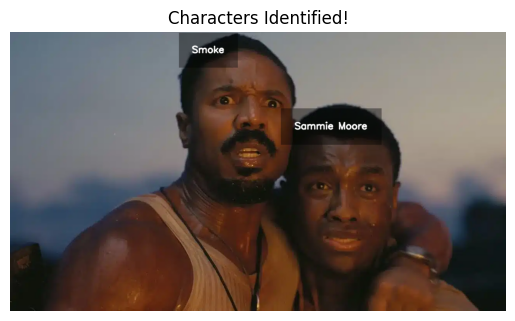

/Users/celestevandokkum/miniconda3/envs/face_blindness/lib/python3.8/site-packages/insightface/utils/transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4


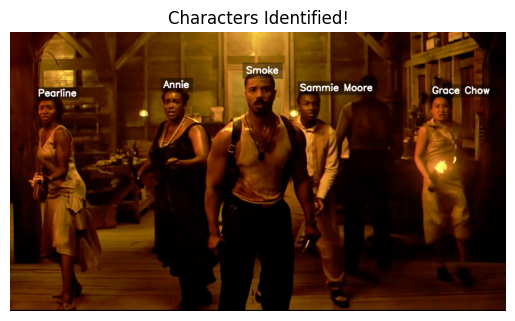

/Users/celestevandokkum/miniconda3/envs/face_blindness/lib/python3.8/site-packages/insightface/utils/transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4


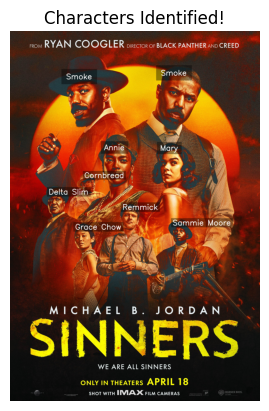

/Users/celestevandokkum/miniconda3/envs/face_blindness/lib/python3.8/site-packages/insightface/utils/transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4


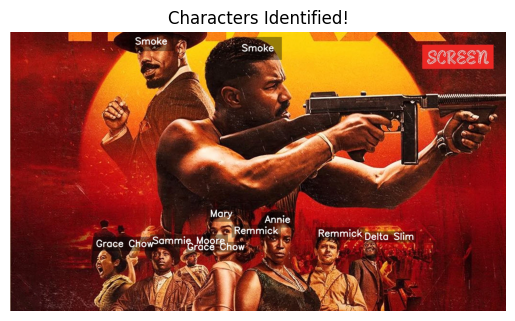

/Users/celestevandokkum/miniconda3/envs/face_blindness/lib/python3.8/site-packages/insightface/utils/transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4


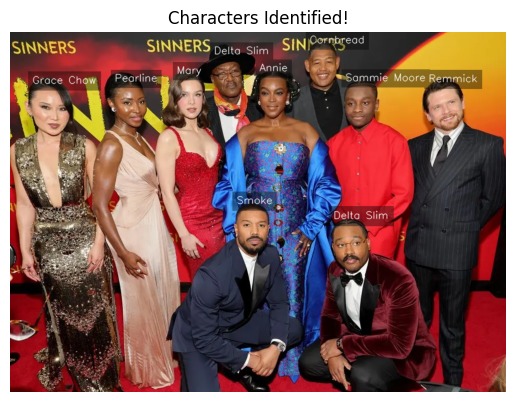

In [ ]:
annotate_all_faces("./faces/ss.png")
annotate_all_faces("./faces/more.jpg")
annotate_all_faces("./faces/ems-2.jpg")
annotate_all_faces("./faces/cover.png")
annotate_all_faces("./faces/scast.png")

/Users/celestevandokkum/miniconda3/envs/face_blindness/lib/python3.8/site-packages/insightface/utils/transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4


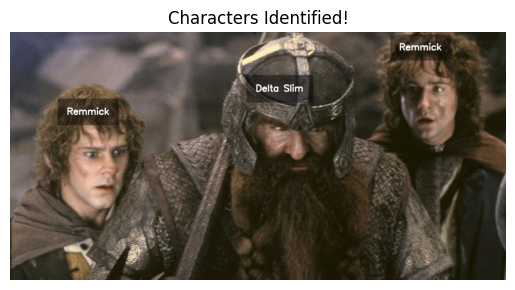

In [ ]:

# actor = predict_person("./faces/try.png")
# print(actor)
import math
import matplotlib.pyplot as plt
annotate_all_faces("./faces/gimliplus.jpg")


# print(predict_person("./faces/try2.png"))


/Users/celestevandokkum/miniconda3/envs/face_blindness/lib/python3.8/site-packages/insightface/utils/transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4


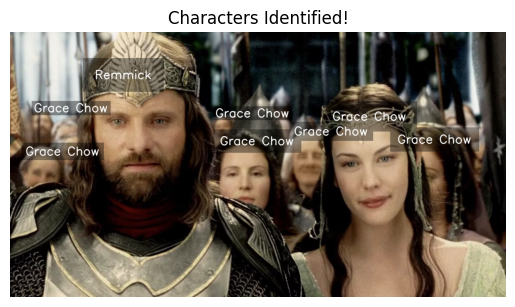

In [ ]:
# annotate_all_faces("./faces/fellowship.jpg")
annotate_all_faces("./faces/poof.png")

/Users/celestevandokkum/miniconda3/envs/face_blindness/lib/python3.8/site-packages/insightface/utils/transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4


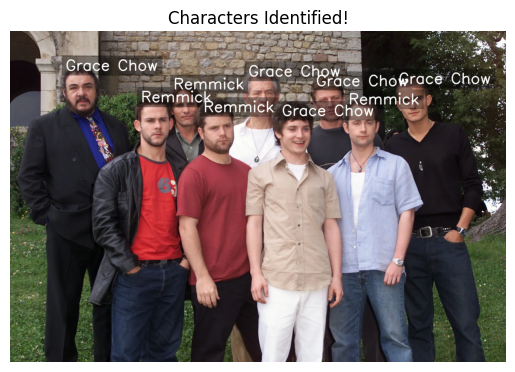

In [ ]:
annotate_all_faces("./faces/cast_modern.png")

--------------------